In [13]:
import numpy as np
from helpers import load_data
import scipy.sparse as sp

def read_submission_files(files, path_root = '../submission/'):
    matrix_list = []
    for i,file_ in enumerate(files):
        matrix = load_data(path_root+file_)
        matrix_list.append(matrix.copy())
    return matrix_list

def read_numpy_files(files, path_root = '../submission/'):
    matrix_list = []
    for i,file_ in enumerate(files):
        matrix = np.load(path_root + file_)
        matrix_list.append(matrix.copy())
    return matrix_list

files_submission = [ \
        'submission_0.06255_norm_unrounded_0.98431kaggle.csv', \
        'submission_surprise_unrounded_0.99256.csv']
files_train = [ \
        'train_surprise_unrounded_0.99256.csv']
files_full = []

file_train_true = '../data/data_train.csv'
#file_test_true = '../data/sampleSubmission.csv' 

errors_submission = [0.98431, 0.99256]

train_est = read_submission_files(files_train)
submission_est = read_submission_files(files_submission)

train_true = load_data(file_train_true)


number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000


item min, max, mean: 8 4590 1176.63663664


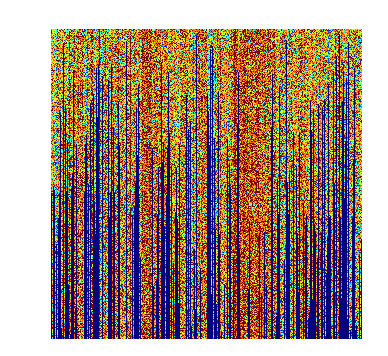

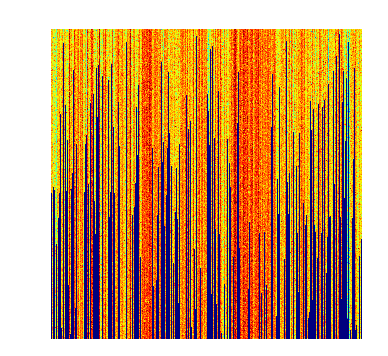

In [29]:
import matplotlib.pyplot as plt
% matplotlib inline

def statistics(sparse_matrix):
    rows, cols, ratings = sp.find(sparse_matrix)
    user_ratings = np.zeros(1000)
    item_ratings = np.zeros(10000)
    for i in range(10000):
        item_ratings[i] = np.count_nonzero(rows==i)
    for i in range(1000):
        user_ratings[i] = np.count_nonzero(cols==i)
    print('item min={},max={},min={}'.format(np.min(item_ratings),np.max(item_ratings),np.mean(item_ratings)))
    print('user min={},max={},min={}'.format(np.min(user_ratings),np.max(user_ratings),np.mean(user_ratings)))
    return item_ratings, user_ratings

def matrix_plot(dense_matrix, fname, cutoff=0):
    if cutoff > 0:
        ax = plt.matshow(dense_matrix[:cutoff,:])
    else:
        ax = plt.matshow(dense_matrix)
    plt.axis('off')
    plt.savefig(fname)

def create_sparse_matrix_plot(sparse_matrix, fname='',cutoff=1000):
    # TODO: doesn't work for axis=1 because of how axes are organized!
    ''' Create a dense matrix plot, squeezing all entries along specified axis.
    input:
        sparse_matrix    - scipy sparse matrix to visualize
        axis             - axis along which all nnz-elements will be squeezed.
    '''
    rows,cols,ratings = sp.find(sparse_matrix) 
    ratings_dense = np.zeros(sparse_matrix.shape)
    i_dense = 0
    i_total = []
    last_index = 0
    for i, rating in enumerate(ratings):
        index = cols[i]
        if index > last_index:
            i_total.append(i_dense)
            i_dense = 0
        ratings_dense[i_dense,index] = rating
        last_index = index
        i_dense += 1
    i_max=np.max(i_total)
    matrix_plot(ratings_dense, fname, min(i_max,cutoff))
    return i_total, ratings_dense[:i_max,:]

#its, uss = statistics(train_true)
dense_matrices=[]
i_total, ratings_dense1 = create_matrix_plot(train_true, '../results/matrix_train.png')
dense_matrices.append(ratings_dense1.copy())
#j_total, _ = create_matrix_plot(train_true, axis=1)
print('item min, max, mean:',np.min(i_total), np.max(i_total), np.mean(i_total))
for i,matrix_est in enumerate(train_est):
    __, ratings_dense2 = create_matrix_plot(matrix_est, '../results/matrix_{}'.format(i+1))
    dense_matrices.append(ratings_dense2.copy())

4.0


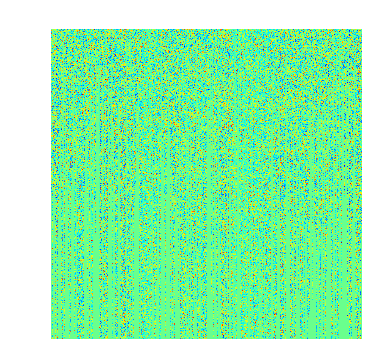

In [30]:
diff_matrix = dense_matrices[1]-dense_matrices[0]
print(np.max(diff_matrix))
matrix_plot(diff_matrix, '../results/matrix_diff0.png', 1000)

In [37]:
def linear_blending(train_est, submissions_est, train_true):
    '''
    Do linear blending of different methods as described in:
    /http://www.commendo.at/UserFiles/commendo/File/Presentation_GrandPrize.pdf
    '''
    def create_matrix(matrix_list): 
        ''' 
        create P or Q matrix as described in 
        input:
        '''
        P_or_Q = np.empty((matrix_list[0].nnz, len(matrix_list)))
        for i,matrix in enumerate(matrix_list):
            __,__,ratings = sp.find(matrix)
            P_or_Q[:,i] = ratings
        return P_or_Q
        
    def get_predictions(P,Q,r):
        '''
        get predictions as best weighted combination of Q.
        '''
        x = np.linalg.solve(np.dot(P.T, P),np.dot(P.T,r))
        q_hat = np.dot(Q, x)
        return q_hat 
    
    P = create_matrix(train_est)
    Q = create_matrix(train_est)
    __, __, r = sp.find(train_true)
    q_hat = get_predictions(P, Q, r)
    return q_hat

q_hat = linear_blending(train_est, submission_est, train_true)
print(q_hat)

[ 3.54538578  3.76064522  2.94520378 ...,  3.77359974  3.37809859
  3.74934269]


NameError: name 'r' is not defined